In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm

torch.random.manual_seed(42)
np.random.seed(42)

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, 2:]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([99677, 6])
normalized X mean: -1.1799484138211669
X std: 1.0505892613255765


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_2.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
def inference(model, total_size, batch_size, coeffs):
    num = total_size
    batchsize = batch_size
    n_gaussian = model.n_gaussian
    pis = torch.zeros((num, n_gaussian))
    locs = torch.zeros((num, n_gaussian, output_dim))
    scales = torch.zeros((num, n_gaussian, output_dim))
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(int(np.ceil(num / batchsize)))):
            batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
            pi, normal = model(batch)
            pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
            locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
            scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()
    return pis, locs, scales

def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik

def get_peak_pred(pis, locs, scales, n_step=1000, verbose=False):
    num = len(pis); output_dim = locs.shape[-1]
    pred_global = torch.zeros((num, output_dim))
    pred_global_loglik = torch.zeros((num, output_dim))
    pred_close = torch.zeros((num, output_dim))
    pred_close_loglik = torch.zeros((num, output_dim))
    grid = [torch.linspace(0, 1, n_step),
            torch.linspace(-4, -2, n_step),
            torch.linspace(-4, 0, n_step),
            torch.linspace(-0.6, 0.6, n_step),
            torch.linspace(0, 2, n_step),
            torch.linspace(-1, 0, n_step)]
    for dim in tqdm(range(output_dim)):
        param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
        loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
        for i in tqdm(range(num)):
            peaks = find_peaks(loglik[i])[0]
            if len(peaks) == 0:
                pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_global_loglik[i, dim] = torch.max(loglik[i])
                pred_close_loglik[i, dim] = torch.max(loglik[i])
                if verbose:
                    print('no peak found, use maximum instead')
                    plt.plot(grid[dim], loglik[i])
                    plt.vlines(Y[i, dim], 0, 10, color='red')
                    plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
                    print(Y[i, dim])
                    plt.show()
            else:
                order = torch.argsort(loglik[i, peaks], descending=True)
                global_peak = grid[dim][peaks[order[0]]]
                close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
                pred_global[i, dim] = global_peak
                pred_close[i, dim] = close_peak
                pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
                pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
    return pred_global, pred_global_loglik, pred_close, pred_close_loglik

def plot_params(num, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik):
    plt.axis('square')
    plt.xlim(-4, 0)
    plt.ylim(-4, 0)
    plt.xlabel(r'actual $\log_{10}q$')
    plt.ylabel(r'predicted $\log_{10}q$')
    plt.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='global', alpha=0.2)
    plt.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Oranges', label='close', alpha=0.2)
    plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
    plt.colorbar()
    plt.legend()
    plt.show()
    print('mse of log10q global: ', torch.mean((Y[:num, 2] -  pred_global.numpy()[:num, 2])**2).detach().cpu().item())
    print('mse of log10q close: ', torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 2]>np.log(2*1/4)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 2][constraint_ind]==pred_close[:num, 2][constraint_ind]).item()/torch.sum(constraint_ind).item())
    plt.axis('square')
    plt.xlim(-0.6, 0.6)
    plt.ylim(-0.6, 0.6)
    plt.xlabel(r'actual $\log_{10}s$')
    plt.ylabel(r'predicted $\log_{10}s$')
    plt.scatter(Y[:num, 3], pred_global.numpy()[:num, 3], s=3, cmap='Blues', label='global', alpha=0.2)
    plt.scatter(Y[:num, 3], pred_close.numpy()[:num, 3], s=3, cmap='Oranges', label='close', alpha=0.2)
    plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
    plt.colorbar()
    plt.legend()
    plt.show()
    print('mse of log10s global: ', torch.mean((Y[:num, 3] -  pred_global.numpy()[:num, 3])**2).detach().cpu().item())
    print('mse of log10s close: ', torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 3]>np.log(2*1/1.2)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 3][constraint_ind]==pred_close[:num, 3][constraint_ind]).item()/torch.sum(constraint_ind).item())
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel(r'actual $u_0$')
    plt.ylabel(r'predicted $u_0$')
    plt.scatter(Y[:num, 0], pred_global.numpy()[:num, 0], s=3, cmap='Blues', label='global', alpha=0.2)
    plt.scatter(Y[:num, 0], pred_close.numpy()[:num, 0], s=3, cmap='Oranges', label='close', alpha=0.2)
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
    plt.colorbar()
    plt.legend()
    plt.show()
    print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_global.numpy()[:num, 0])**2).detach().cpu().item())
    print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 0]>np.log(2*1/1)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 0][constraint_ind]==pred_close[:num, 0][constraint_ind]).item()/torch.sum(constraint_ind).item())
    plt.axis('square')
    plt.xlim(-4, -2)
    plt.ylim(-4, -2)
    plt.xlabel(r'actual $\log_{10}\rho$')
    plt.ylabel(r'predicted $\log_{10}\rho$')
    plt.scatter(Y[:num, 1], pred_global.numpy()[:num, 1], s=3, cmap='Blues', label='global', alpha=0.2)
    plt.scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Oranges', label='close', alpha=0.2)
    plt.plot(np.linspace(-4, -2), np.linspace(-4, -2), color='b', linestyle='dashed')
    plt.colorbar()
    plt.legend()
    plt.show()
    print('mse of log10rho global: ', torch.mean((Y[:num, 1] -  pred_global.numpy()[:num, 1])**2).detach().cpu().item())
    print('mse of log10rho close: ', torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 1]>np.log(2*1/2)
    print('constraint', torch.sum(constraint_ind).item()/num)
    if torch.sum(constraint_ind).item() > 0:
        print('correct', torch.sum(pred_global[:num, 1][constraint_ind]==pred_close[:num, 1][constraint_ind]).item()/torch.sum(constraint_ind).item())
    plt.axis('square')
    plt.xlim(0, 360)
    plt.ylim(0, 360)
    plt.xlabel(r'actual $\alpha$')
    plt.ylabel(r'predicted $\alpha$')
    plt.scatter(Y[:num, 4]*180, pred_global.numpy()[:num, 4]*180, s=3, cmap='Blues', label='global', alpha=0.2)
    plt.scatter(Y[:num, 4]*180, pred_close.numpy()[:num, 4]*180, s=3, cmap='Oranges', label='close', alpha=0.2)
    plt.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
    plt.colorbar()
    plt.legend()
    plt.show()
    print('mse of alpha global: ', torch.mean((Y[:num, 4]*180 -  pred_global.numpy()[:num, 4]*180)**2).detach().cpu().item())
    print('mse of alpha close: ', torch.mean((Y[:num, 4]*180 -  pred_close.numpy()[:num, 4]*180)**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 4]>np.log(2*1/2)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 4][constraint_ind]==pred_close[:num, 4][constraint_ind]).item()/torch.sum(constraint_ind).item())
    plt.axis('square')
    plt.xlim(-1, 0)
    plt.ylim(-1, 0)
    plt.xlabel(r'actual $\log_{10}f_s$')
    plt.ylabel(r'predicted $\log_{10}f_s$')
    plt.scatter(Y[:num, 5], pred_global.numpy()[:num, 5], s=3, cmap='Blues', label='global', alpha=0.2)
    plt.scatter(Y[:num, 5], pred_close.numpy()[:num, 5], s=3, cmap='Oranges', label='close', alpha=0.2)
    plt.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
    plt.colorbar()
    plt.legend()
    plt.show()
    print('mse of log10fs global: ', torch.mean((Y[:num, 5] -  pred_global.numpy()[:num, 5])**2).detach().cpu().item())
    print('mse of log10fs close: ', torch.mean((Y[:num, 5] -  pred_close.numpy()[:num, 5])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 5]>np.log(2*1/1)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 5][constraint_ind]==pred_close[:num, 5][constraint_ind]).item()/torch.sum(constraint_ind).item())

def simulate_lc(t_0, t_E, u_0, lgrho, lgq, lgs, alpha_180, lgfs):
    fs = 10**lgfs
    parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': 10**lgrho, 
            'q': 10**lgq, 
            's': 10**lgs, 
            'alpha': alpha_180*180,
        }
    modelmm = mm.Model(parameters, coords=None)
    times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
    modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
    magnification = modelmm.get_magnification(times)
    flux = 1000 * (magnification + (1-fs)/fs)
    mag = (22 - 2.5 * np.log10(flux) - 14.5 - 2.5*np.log10(fs)) / 0.2
    lc = np.stack([times, mag], axis=-1)
    return lc


In [7]:
size = 4096 * 4
pis, locs, scales = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

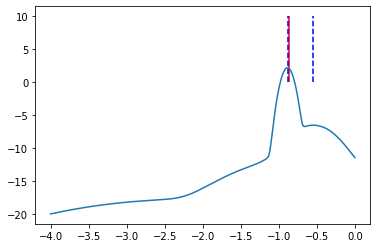

In [6]:
i = 0
qgrid = torch.linspace(-4, 0, 1000)
qlist = qgrid.reshape(-1, 1, 1).tile(1, size, 1)
plt.plot(np.linspace(-4, 0, 1000), get_loglik(pis, locs, scales, qlist, margin_dim=2, exp=False)[:, i])
peaks = find_peaks(get_loglik(pis, locs, scales, qlist, margin_dim=2, exp=False).transpose(1, 0)[i])[0]
plt.vlines(Y[i, 2], 0, 10, color='red')
plt.vlines(np.linspace(-4, 0, 1000)[peaks], 0, 10, color='blue', linestyles='dashed')

In [8]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [10]:
pred_global_loglik.sum(dim=1).mean(), pred_close_loglik.sum(dim=1).mean()

(tensor(11.7664), tensor(11.1720))

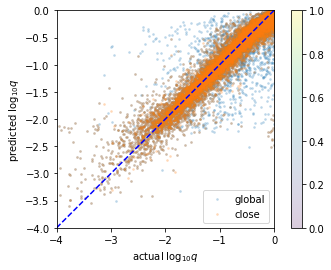

mse of log10q global:  0.058506045059685166
mse of log10q close:  0.03001852494024991
constraint 0.99853515625
correct 0.9235941320293398


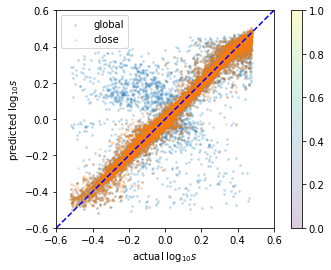

mse of log10s global:  0.010215493728861779
mse of log10s close:  0.0010945106876376755
constraint 0.996826171875
correct 0.8942566740142053


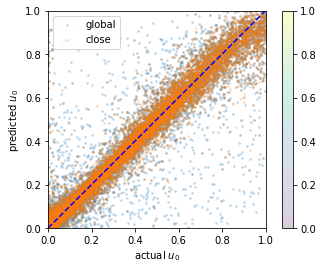

mse of u0:  0.008804528027756955
mse of u0:  0.0034933022048213875
constraint 0.98956298828125
correct 0.9112440634059088


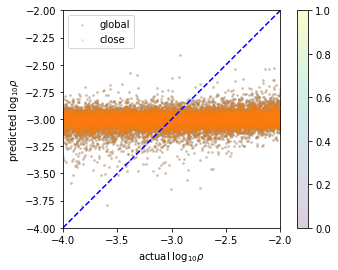

mse of log10rho global:  0.3255577135188288
mse of log10rho close:  0.3255577135188288
constraint 0.00018310546875
correct 1.0


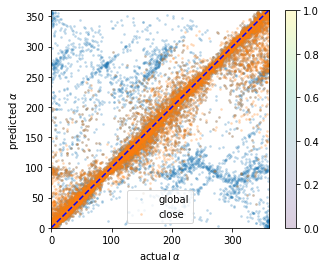

mse of alpha global:  5217.778351422326
mse of alpha close:  653.4105318672496
constraint 0.97674560546875
correct 0.829969380741111


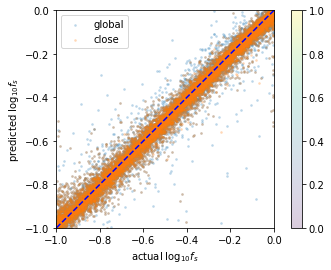

mse of log10fs global:  0.002108120845406621
mse of log10fs close:  0.0012673264240405965
constraint 0.997802734375
correct 0.9483117200880842


In [11]:
plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik)

# Subsample

In [12]:
n_points = 10
subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

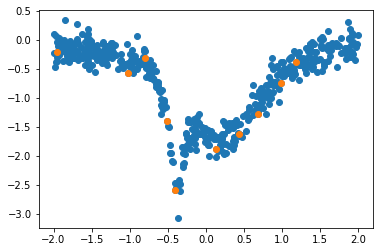

In [13]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_sub[i, :, 0], X_sub[i, :, 1])

In [14]:
# CDE interpolation with log_sig
depth = 3; window_length = max(n_points//100, 1)
logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [15]:
pis, locs, scales = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
pred_sub = get_peak_pred(pis, locs, scales)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

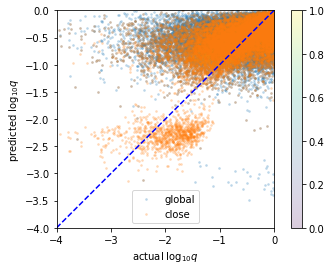

mse of log10q global:  0.5309912116380466
mse of log10q close:  0.3244407686174643
constraint 0.99871826171875
correct 0.7267004827965532


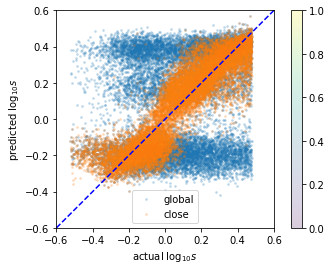

mse of log10s global:  0.09797216750221269
mse of log10s close:  0.010819067691384849
constraint 1.0
correct 0.3665771484375


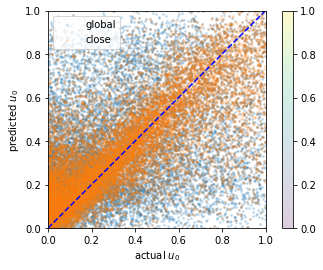

mse of u0:  0.0822897138881676
mse of u0:  0.037669743882624576
constraint 0.97454833984375
correct 0.6006763950648212


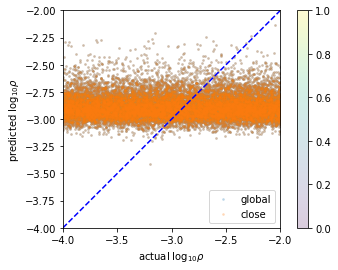

mse of log10rho global:  0.3577383448992768
mse of log10rho close:  0.3577383448992768
constraint 0.0


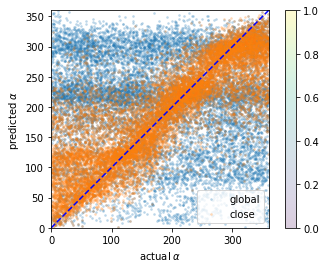

mse of alpha global:  16572.33032775272
mse of alpha close:  3482.396565279225
constraint 0.98846435546875
correct 0.41234949058351344


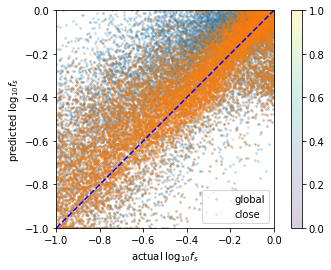

mse of log10fs global:  0.052861748081018
mse of log10fs close:  0.029595371503196466
constraint 0.90478515625
correct 0.6469913653534809


In [17]:
plot_params(size, Y, *pred_sub)

In [25]:
n_points_list = [500, 200, 100, 50, 20, 10]
mse_global = np.zeros((len(n_points_list), output_dim))
mse_close = np.zeros((len(n_points_list), output_dim))
loglik_global = np.zeros((len(n_points_list), output_dim))
loglik_close = np.zeros((len(n_points_list), output_dim))
for i in tqdm(range(len(n_points_list))):
    n_points = n_points_list[i]
    subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
    X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
    order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
    X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

    # CDE interpolation with log_sig
    depth = 3; window_length = max(n_points//100, 1)
    logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

    pis, locs, scales = inference(model, size, 4096, coeffs)
    pred_sub = get_peak_pred(pis, locs, scales)

    mse_global[i] = torch.mean((pred_sub[0] - Y[:size])**2, dim=0).numpy()
    mse_close[i] = torch.mean((pred_sub[2] - Y[:size])**2, dim=0).numpy()
    loglik_global[i] = torch.mean(pred_sub[1], dim=0).numpy()
    loglik_close[i] = torch.mean(pred_sub[3], dim=0).numpy()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

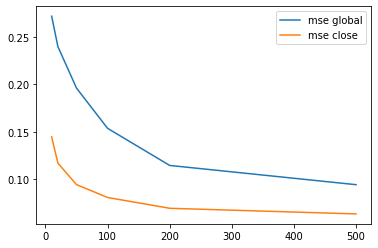

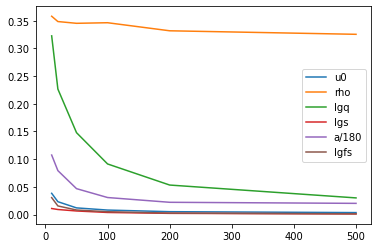

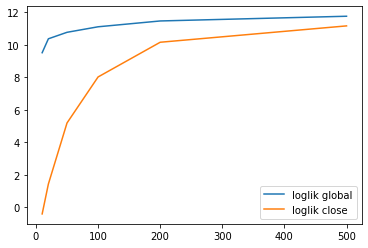

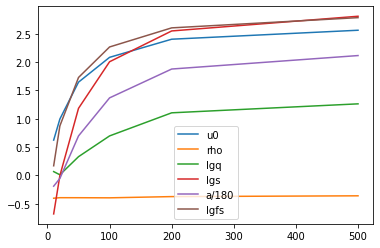

In [37]:
plt.plot(n_points_list, mse_global.mean(1), label='mse global')
plt.plot(n_points_list, mse_close.mean(1), label='mse close')
plt.legend()
plt.show()
plt.plot(n_points_list, mse_close, label=['u0', 'rho', 'lgq', 'lgs', 'a/180', 'lgfs'])
plt.legend()
plt.show()
plt.plot(n_points_list, loglik_global.sum(1), label='loglik global')
plt.plot(n_points_list, loglik_close.sum(1), label='loglik close')
plt.legend()
plt.show()
plt.plot(n_points_list, loglik_close, label=['u0', 'rho', 'lgq', 'lgs', 'a/180', 'lgfs'])
plt.legend()
plt.show()

# Gap
Gap length: 5 days = 1/6 tE = 1/24 4tE

In [18]:
n_chunks = 25
gap_len = int(500 / n_chunks)
gap_left = torch.randint(0, X.shape[1]-gap_len, (len(X),))
X_gap = torch.zeros((X.shape[0], X.shape[1]-gap_len, X.shape[2]))
for i in tqdm(range(len(X))):
    left, gap, right = torch.split(X[i], [gap_left[i], gap_len, X.shape[1]-gap_left[i]-gap_len], dim=0)
    lc = torch.vstack([left, right])
    X_gap[i] = lc

  0%|          | 0/99677 [00:00<?, ?it/s]

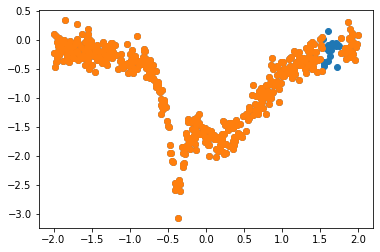

In [19]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1])

In [20]:
# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [21]:
pis, locs, scales = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
pred_gap = get_peak_pred(pis, locs, scales)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

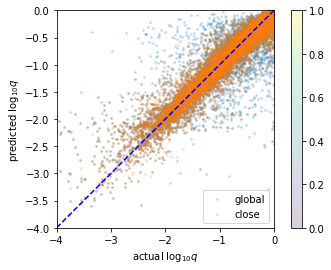

mse of log10q global:  0.06833128837637059
mse of log10q close:  0.03415821159960167
constraint 0.99859619140625
correct 0.912902634313306


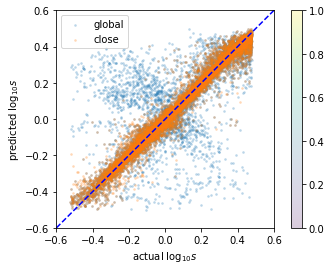

mse of log10s global:  0.01173347140086645
mse of log10s close:  0.0013693093784732753
constraint 0.9970703125
correct 0.8781831537708129


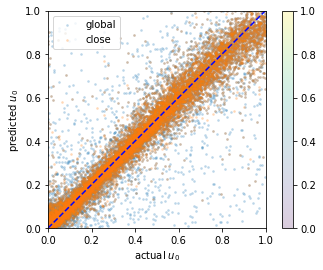

mse of u0:  0.009549114861993545
mse of u0:  0.0035659677430562196
constraint 0.99005126953125
correct 0.9011774859749707


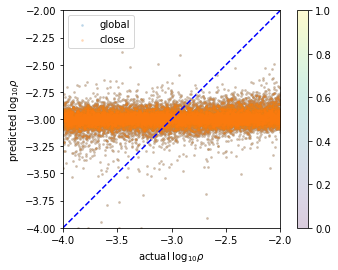

mse of log10rho global:  0.32555623233638536
mse of log10rho close:  0.32555623233638536
constraint 0.0003662109375
correct 1.0


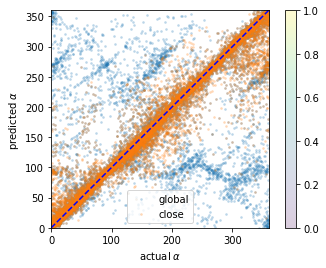

mse of alpha global:  5492.947572618461
mse of alpha close:  694.7460500044818
constraint 0.97637939453125
correct 0.8142151653435019


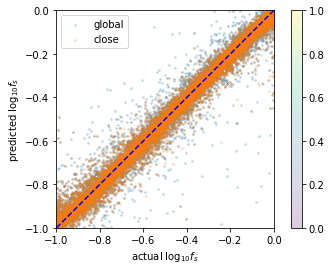

mse of log10fs global:  0.0025809431654487966
mse of log10fs close:  0.0015035803964484698
constraint 0.99725341796875
correct 0.9411224677152824


In [23]:
plot_params(size, Y, *pred_gap)

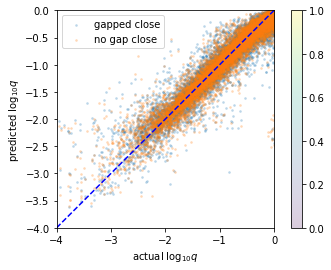

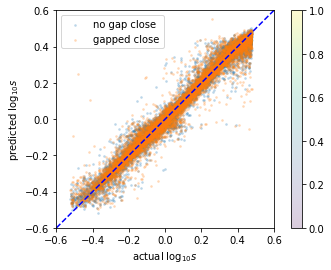

In [26]:
num = size
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Blues', label='no gap close', alpha=0.2)
plt.scatter(Y[:num, 2], pred_gap[2].numpy()[:num, 2], s=3, cmap='Oranges', label='gapped close', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_close.numpy()[:num, 3], s=3, cmap='Blues', label='no gap close', alpha=0.2)
plt.scatter(Y[:num, 3], pred_gap[2].numpy()[:num, 3], s=3, cmap='Oranges', label='gapped close', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()

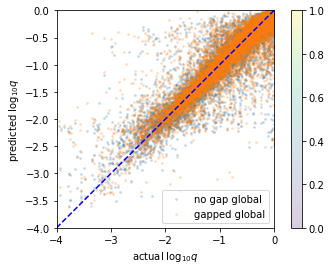

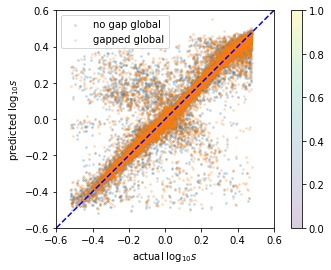

In [27]:
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='no gap global', alpha=0.2)
plt.scatter(Y[:num, 2], pred_gap[0].numpy()[:num, 2], s=3, cmap='Oranges', label='gapped global', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_global.numpy()[:num, 3], s=3, cmap='Blues', label='no gap global', alpha=0.2)
plt.scatter(Y[:num, 3], pred_gap[0].numpy()[:num, 3], s=3, cmap='Oranges', label='gapped global', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()

In [18]:
i = torch.argmax(torch.mean((pred_global - pred_gap[0])**2, dim=-1))
i, Y[i], pred_global[i], pred_gap[0][i]

(tensor(4818),
 tensor([ 0.2068, -2.7223, -0.2654,  0.2342,  1.4883, -0.8250],
        dtype=torch.float64),
 tensor([ 0.2032, -2.9810, -0.1121,  0.2444,  1.4875, -0.8649]),
 tensor([ 0.9039, -3.1371, -3.4595,  0.2925,  1.6857, -0.8749]))

(tensor([ 0.3251, -2.7517, -0.8641,  0.3002,  1.2213, -0.4586],
        dtype=torch.float64),
 tensor([ 0.3524, -2.9530, -0.8849,  0.2961,  1.2392, -0.4324]),
 tensor([ 0.3614, -2.9570, -0.8849,  0.3009,  1.2412, -0.4264]))

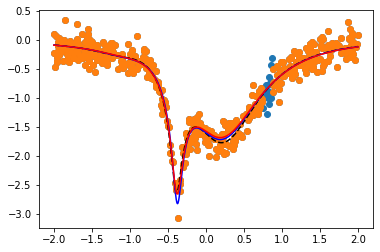

In [23]:
i = 0
# plt.xlim(-0.5, 0.5)
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1])
lc_true = simulate_lc(0, 1, *Y[i].tolist())
lc_pred = simulate_lc(0, 1, *pred_close[i].tolist())
lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][i].tolist())
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', )
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', )
Y[i], pred_close[i], pred_gap[2][i]

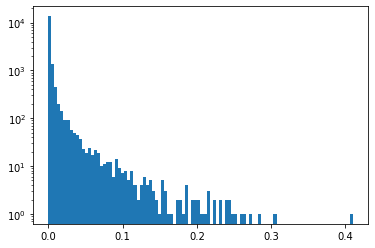

In [31]:
plt.hist((torch.mean(X[:size, :, 1], dim=1) - torch.mean(X_gap[:size, :, 1], dim=1)).numpy()**2, bins=100, log=True)
plt.show()

(tensor([ 0.0522, -2.2242, -2.0713,  0.3865,  0.9135, -0.0836],
        dtype=torch.float64),
 tensor([ 0.0501, -3.0310, -1.9419,  0.3982,  0.6867, -0.0831]),
 tensor([ 0.0641, -3.0090, -1.7818,  0.2529,  0.6086, -0.0891]))

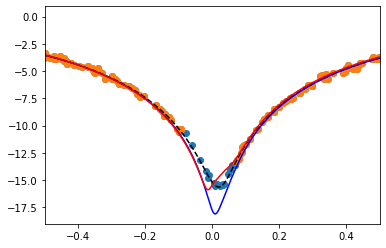

In [52]:
ind = (torch.mean(X[:, :, 1], dim=1) - torch.mean(X_gap[:, :, 1], dim=1)).numpy()**2 > 0.05
ind[size:] = False
i = 7
plt.xlim(-0.5, 0.5)
plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1])
plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1])
lc_true = simulate_lc(0, 1, *Y[ind][i].tolist())
lc_pred = simulate_lc(0, 1, *pred_close[ind[:size]][i].tolist())
lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist())
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', )
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', )
Y[ind][i], pred_close[ind[:size]][i], pred_gap[2][ind[:size]][i]

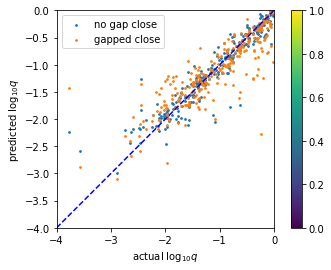

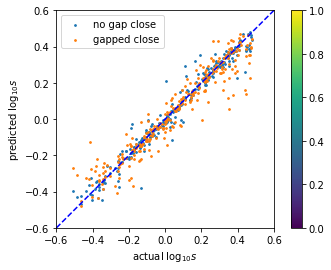

In [54]:
num = size
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[ind][:num, 2], pred_close.numpy()[ind[:size]][:num, 2], s=3, cmap='Blues', label='no gap close', alpha=1)
plt.scatter(Y[ind][:num, 2], pred_gap[2].numpy()[ind[:size]][:num, 2], s=3, cmap='Oranges', label='gapped close', alpha=1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[ind][:num, 3], pred_close.numpy()[ind[:size]][:num, 3], s=3, cmap='Blues', label='no gap close', alpha=1)
plt.scatter(Y[ind][:num, 3], pred_gap[2].numpy()[ind[:size]][:num, 3], s=3, cmap='Oranges', label='gapped close', alpha=1)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()